In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from utils.oversampling import fit_resample
from utils.data_processer import *

In [2]:
data = pd.read_csv("../creditcard_2021.csv")
print(f"Number of samples: {len(data)}")
print(f"Number of fraudolent transaction: {(data['Class'] == 1).sum()}")
print(f"Ratio of fraudolent transaction: {data['Class'].mean()}")

Number of samples: 284807
Number of fraudolent transaction: 492
Ratio of fraudolent transaction: 0.001727485630620034


In [53]:
class ANN:
    def __init__(self, layers_size=None, act_func=jnp.tanh, out_act_fun = jax.nn.sigmoid):
        self.layers_size = layers_size
        self.act_func = act_func 
        self.out_act_fun = out_act_fun

    def initialize_parameters(self, layers_size=None):
        """
            Sets the parameters of the artificial neural network given the number of
            neurons of its layers, namely it sets the matrix of weights and the bias
            vector for each layer 
          
            Parameters:
            layers_size: list - ordered sizes of the layers of the artificial neural network
            
            Raises:
            exception: if layers_size is not provided
        """

        if layers_size is None:
            raise Exception("Size of layers not provided")
        
        layers_size = jnp.array(layers_size)
        
        np.random.seed(0) # For reproducibility
        self.layers_size = layers_size
        params = list()
        
        for i in range(len(self.layers_size) - 1):
            W = np.random.randn(self.layers_size[i+1], self.layers_size[i])
            b = np.zeros((self.layers_size[i+1], 1))
            params.append(W)
            params.append(b)
        
        return params
    
    def MSW(self, params):
        """
        Computes the sum of the squared values of the weights of the artificial neural
        network
    
        Parameters:
        params: list - parameters of the artificial neural network, namely weights and biases
        
        Returns:
        float - sum of the squared values of the weights of the artificial neural network
        """
        
        # Extract weights
        weights = params[::2]
        
        # Calculate MSW
        partial_sum = 0.0
        n_weights = 0
        for W in weights:
            partial_sum = partial_sum + jnp.sum(W * W)
            n_weights = n_weights + W.size
            
        return partial_sum / n_weights
    
    # Loss functions
    def cross_entropy(self):
        @jax.jit
        def callable(x=None, y=None, params=None):
            """
                Computes the Cross Entropy Cost function
                
                Parameters:
                x: ndarray - input of the artificial neural network
                y: ndarray - correct value of the output, one-hot representation
                
                Returns:
                float - Cross Entropy Cost between the predictions of the artificial neural network and the correct values
                
                Raises:
                exception: if x is not provided
                exception: if y is not provided
                exception: if params are not provided
            """
            
            if x is None:
                raise Exception("x is not provided")
            if y is None:
                raise Exception("y is not provided")
            if params is None:
                raise Exception("params are not provided")
        
            y_pred = self.predict(x, params)
            return -jnp.mean(y * jnp.log(y_pred) + (1 - y) * jnp.log(1 - y_pred))
        return callable
    
    def mean_squared_error(self):
        @jax.jit
        def callable(x, y, params):
            """
                Computes the Mean Squared Error
                
                Parameters:
                x: ndarray - input of the artificial neural network
                y: ndarray - correct value of the output, one-hot representation
                
                Returns:
                float - Mean Squared Error between the predictions of the artificial neural network and the correct values
                
                Raises:
                exception: if x is not provided
                exception: if y is not provided
                exception: if params are not provided
            """
            
            if x is None:
                raise Exception("x is not provided")
            if y is None:
                raise Exception("y is not provided")
            if params is None:
                raise Exception("params are not provided")
            
            y_pred = self.predict(x, params)
            return jnp.mean((y_pred - y) ** 2)
        return callable
    
    def loss_regularization(self, loss_function, penalization):
        @jax.jit
        def callable(x=None, y=None, params=None):
            """
                Computes the loss function applying regularization to the given loss function with penalization 
            
                Parameters:
                x: ndarray - input of the artificial neural network
                y: ndarray - correct value of the output
                params: list - parameters of the artificial neural network, namely weights and biases
                penalization: float - weight to which the MSW is multiplied and 
                                    that makes possible to modify the impact of the regularization term
                Returns:
                float - loss function value between the predictions of the artificial neural network
                        and the correct values with regularization term
              
                Raises:
                exception: if x is not provided
                exception: if y is not provided
                exception: if params are not provided
            """
                
            if x is None:
                raise Exception("x is not provided")
            if y is None:
                raise Exception("y is not provided")
            if params is None:
                raise Exception("params are not provided")
            
            return loss_function(x, y, params) + penalization/(2 * x.shape[0]) * self.MSW(params)
        return callable
    
    # Optimisation algorithms
    def SGD(
            self, 
            loss_function, 
            epochs=1000, 
            batch_size=128, 
            learning_rate_min=1e-3, 
            learning_rate_max=1e-1, 
            learning_rate_decay=1000,
            
    ):
        def callable(x_train, y_train, params):
            """
                Stochastic gradient descent method with mini-batch and learning rate decay
            
                Parameters:
                x_train: ndarray - training set of the dataset to fit
                y_train: ndarray - training set's sample's labels
                params: list - parameters of the artificial neural network, namely weights and biases
                epochs: int - number of epochs to perform
                batch_size: int, optional - size of the batches to be used for computing the gradient
                learning_rate_min: float - minimum learning rate used in the training phase
                learning_rate_max: float - maximum learning rate used in the training phase
                learning_rate_decay: float - learning rate decay used in the training phase
            
                Returns:
                parameters: list - trained parameters of the artificial neural network, 
                                    namely weights and biases optimized for fitting the training set
            """
    
            # Number of samples
            num_samples = x_train.shape[0]
        
            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))
        
            # History
            history = list()
            history.append(loss(x_train, y_train, params))
            
            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
        
                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)
                
                # Calculate gradient
                grad_val = grad_loss(x_train[idxs,:], y_train[idxs,:], params)
        
                # Update params
                for i in range(len(params)):
                    params[i] = params[i] - learning_rate * grad_val[i]
                
                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history
        return callable
    
    def SGD_momentum(
            self, 
            loss_function, 
            epochs=1000, 
            batch_size=128, 
            learning_rate_min=1e-3, 
            learning_rate_max=1e-1, 
            learning_rate_decay=1000,
            momentum=0.9,
    ):
        def callable(x_train, y_train, params):
            """
                Stochastic gradient descent method with momentum, mini-batch and learning rate decay
            
                Parameters:
                x_train: ndarray - training set of the dataset to fit
                y_train: ndarray - training set's sample's labels
                params: list - parameters of the artificial neural network, namely weights and biases
                epochs: int - number of epochs to perform
                batch_size: int, optional - size of the batches to be used for computing the gradient
                learning_rate_min: float - minimum learning rate used in the training phase
                learning_rate_max: float - maximum learning rate used in the training phase
                learning_rate_decay: float - learning rate decay used in the training phase
                momentum: float - momentum used in the training phase
            
                Returns:
                parameters: list - trained parameters of the artificial neural network, 
                                    namely weights and biases optimized for fitting the training set
            """
    
            # Number of samples
            num_samples = x_train.shape[0]
        
            # Loss and it's gradient functions
            loss = jax.jit(loss_function)
            grad_loss = jax.jit(jax.grad(loss_function, argnums=2))
            
            # History
            history = list()
            history.append(loss(x_train, y_train, params))
            
            # Initialize velocity
            velocity = list()
            for i in range(len(params)):
                velocity.append(np.zeros_like(params[i]))
                
            for epoch in range(epochs):
                # Get learning rate
                learning_rate = max(learning_rate_min, learning_rate_max * (1 - epoch/learning_rate_decay))
        
                # Select batch_size indices randomly
                idxs = np.random.choice(num_samples, batch_size)
                
                # Calculate gradient
                grad_val = grad_loss(x_train[idxs,:], y_train[idxs,:], params)
                    
                for i in range(len(params)):
                    # Compute velocity[i]
                    velocity[i] = momentum * velocity[i] - learning_rate * grad_val[i]

                    # Update params[i]
                    params[i] = params[i] + velocity[i]
                
                # Update history
                history.append(loss(x_train, y_train, params))
            return params, history
        return callable
    
    def train(self, x_train, y_train, params, opt_algorithm):
        """
            Trains the artificial neural network using one the optimization algorithms
        
            Parameters:
            x_train: ndarray - training set of the dataset to fit
            y_train: ndarray - training set's sample's labels
            params: ndarray - parameters of the artificial neural network, namely weights and biases
            opt_algorithm: callable - optimization algorithm to be used in the training phase

            Returns:
            ndarray - updated weights and bias
            ndarray - history of the loss function
        """
        
        return opt_algorithm(x_train, y_train, params)
    
    def predict(self, x=None, params=None):
        """
            Computes the value of the output of the artificial neural network given an input
        
            Parameters:
            x: ndarray - input of the artificial neural network
            act_func: callable - activation function of the artificial neural network
            out_act_fun: callable - output activation function of the artificial neural network
        
            Returns: 
            ndarray - output value of the artificial neural network
                
            Raises:
            Exception - if x is not provided
            Exception - if parameters were not initialized
        """
        
        if x is None:
            raise Exception("x is not provided")
        if params is None:
            raise Exception("Parameters were not initialized")
        
        # Number of ANN layers
        num_layers = int(len(self.layers_size)) + 1
        
        # Algorithm
        layer = x.T
        weights = params[0::2]
        biases = params[1::2]
        for i in range(num_layers - 2):
            # Update layer values
            layer = weights[i] @ layer + biases[i]
            
            # Apply activation function
            layer = self.act_func(layer)
                  
        # On the output layer it is applied the sigmoid function 
        # since the output is needed to be between 0 and 1
        layer = self.out_act_fun(layer)
        layer = layer.T
        
        return layer

In [54]:
v5 = ['Time', 'V1', 'V7', 'V8', 'V9', 'V11', 'V12', 'V14', 'V15', 'V22', 'V27', 'V28', 'Amount', 'Class']
input = data[v5].to_numpy()

# Data splitting
x_train, y_train, _, _, x_test, y_test = data_split(data_input=input)

# Training set normalisation
x_train_normalized, data_train_min, data_train_max = min_max(data=x_train)

# SMOTE
x_train_synthetic = fit_resample(x_train_normalized[y_train[:, 0] == 1], n_samples=50000)
y_train_synthetic = np.ones((50000,1))

x_train_normalized = np.concatenate((x_train_normalized, x_train_synthetic), axis=0)
y_train = np.concatenate((y_train, y_train_synthetic), axis=0)

In [55]:
# ANN with:
# activation function for each layer: ReLU
# activation function for last layer: Sigmoid
network = ANN(act_func=jnp.tanh, out_act_fun=jax.nn.sigmoid)

# Initialize weights and biases
params = network.initialize_parameters([x_train_normalized.shape[1], 30, 20, 1])

# Train ann, with gradient descent - mean squared error
updated_params, history = network.train(
    x_train = x_train_normalized, 
    y_train = y_train, 
    params = params,    
    opt_algorithm = network.SGD_momentum(
        loss_function=network.cross_entropy()
    )
)

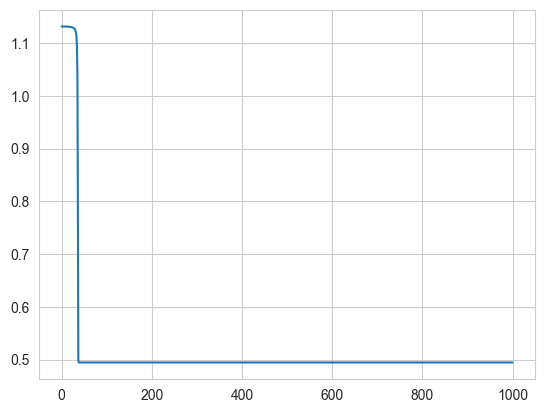

In [56]:
plt.plot(history)

In [57]:
TP = network.predict(x_train_normalized[y_train[:, 0] == 1], updated_params)
TN = 1 - network.predict(x_train_normalized[y_train[:, 0] == 0], updated_params)

accuracy = (sum(TP) + sum(TN)) / x_train_normalized.shape[0]
accuracy * 100

Array([64.87416], dtype=float32)